In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
import torch
from torch.nn import functional as F
from torch import nn, Tensor

In [2]:
# Naive Bayes benchmark
def get_NB_accuracy(x0s,xis_int,train_frac):
    xi_train, xi_test, x0_train, x0_test = train_test_split(xis_int.T, x0s, test_size=1-train_frac, random_state=0)
    gnb = GaussianNB()
    gnb.fit(xi_train, x0_train)
    y_pred = gnb.predict(xi_test)
    return np.sum((x0_test == y_pred))/len(x0_test) 

In [38]:
# Data that will be used
q = 4
l = 4
sigma = 1.0
epsilon = 0.0
seed = 31

N_learn = 500

[q,l,sigma,epsilon,x0s,xis,M_s] = np.load('./sim_data/labeled_data_{}_{}_{}_{:.5f}.npy'.format(q,l,sigma,epsilon),allow_pickle=True)
x0 = x0s[:,seed]
xi = xis[:,:,seed]
train_frac = N_learn/len(x0)
phi_NB = get_NB_accuracy(x0,xi,train_frac)
print('Naives Bayes accuracy: {:.2f}, trained on {} and tested on {} trees.'.format(phi_NB,int(train_frac*len(x0)),int((1-train_frac)*len(x0))))

Naives Bayes accuracy: 0.64, trained on 500 and tested on 9500 trees.


In [39]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [40]:
# convert data to be used in pytorch
sequences = torch.tensor(xi[:,:N_learn].astype(int)) # int8 is too old school for Pytorch
labels = torch.tensor(x0[:N_learn].astype(int))
sequences_test = torch.tensor(xi[:,N_learn:].astype(int))
labels_test = torch.tensor(x0[N_learn:].astype(int))

In [41]:
num_embeddings = q # number of possible values for each position
embedding_size = 128 # some number to be played with
embedding = nn.Embedding(num_embeddings, embedding_size)
embedded_sequences = embedding(sequences)

In [42]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-np.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: Tensor) -> Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


In [43]:
num_heads = 4
encoder_layer = nn.TransformerEncoderLayer(d_model=embedding_size,nhead=num_heads,dim_feedforward = 2048)
transformer_encoder = nn.TransformerEncoder(encoder_layer,num_layers=4)
positional_encoder = PositionalEncoding(d_model=embedding_size)
out = transformer_encoder(positional_encoder(embedded_sequences))

In [44]:
class TransformerClassifier(nn.Module):
    def __init__(self, transformer_encoder,positional_encoder,final_layer):
        super().__init__()
        self.transformer_encoder = transformer_encoder
        self.final_layer = final_layer
        self.pos_encoder = positional_encoder

    def forward(self, x):
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = torch.mean(x.detach(),dim=0)
        x = self.final_layer(x)
        return x

# Number of epochs
num_epochs = 500
losses = np.empty(num_epochs)
acurracies = np.empty(num_epochs)

# Define the final layer
final_layer = nn.Linear(embedding_size,q)

# Add positional encoding to the model

# Create the model
model = TransformerClassifier(transformer_encoder,positional_encoder,final_layer)

# Define the loss function and the optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)

# In your training loop
for epoch in range(num_epochs):
    # Forward pass
    out = model(embedded_sequences)

    # Compute the loss
    loss = loss_fn(out,labels)
    losses[epoch] = loss

    # Compute the accuracy on the training set
    _,predicted = torch.max(out,1)
    accuracy = (predicted == labels).sum().float()/len(labels)
    acurracies[epoch] = accuracy

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (epoch+1)%100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')

Epoch 100, Loss: 1.0122102499008179
Epoch 200, Loss: 1.0033079385757446
Epoch 300, Loss: 0.9771098494529724
Epoch 400, Loss: 0.9559929966926575
Epoch 500, Loss: 0.9692901372909546


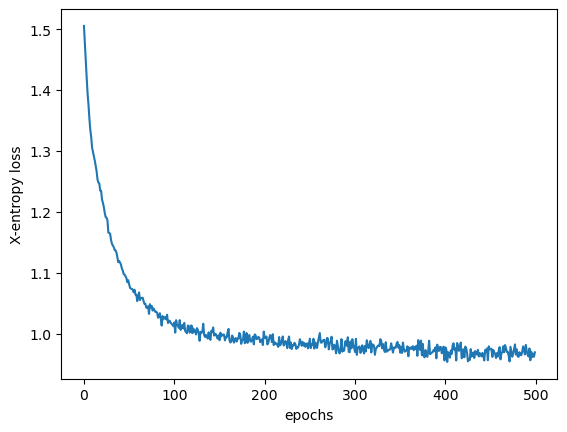

In [49]:
plt.plot(losses)
#plt.xscale('log')
plt.ylabel('X-entropy loss')
plt.xlabel('epochs')
plt.show()

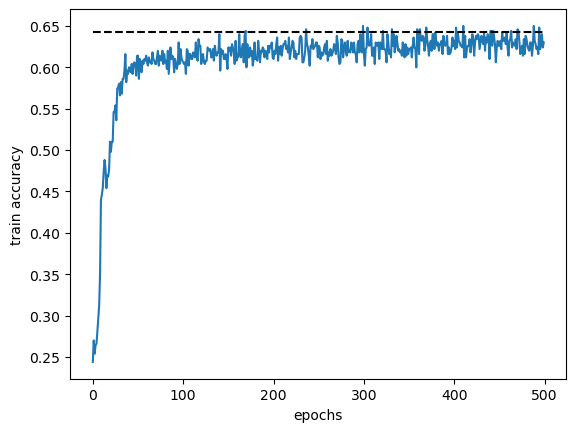

In [47]:
plt.plot(acurracies)
plt.plot(np.arange(num_epochs),phi_NB*np.ones(num_epochs),color='k',ls='--')
#plt.xlim((1,num_epochs))
#plt.xscale('log')
plt.ylabel('train accuracy')
plt.xlabel('epochs')
plt.show()

In [48]:
# Compute the accuracy on the rest of dataset
sequences_test = torch.tensor(xi[:,N_learn:10000].astype(int))
labels_test = torch.tensor(x0[N_learn:10000].astype(int))
embedded_sequences_test = embedding(sequences_test)
out_test = model(embedded_sequences_test)
_,predicted_test = torch.max(out_test,1)
accuracy_test = (predicted_test == labels_test).sum().item()/len(labels_test)
print('Accuracy on the rest of the dataset: {:.2f}'.format(accuracy_test))

Accuracy on the rest of the dataset: 0.58
